# Regional Joint PDF 
We will take two variables and look at the bivariate distribution conditioned on a geographic region.

In [7]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject


In [10]:
def correct_time(ds):
    correct_time = ds['time_bnds'].mean(dim='nbnd')
    correct_time.attrs = ds['time'].attrs
    return ds.assign_coords({"time":correct_time})

In [11]:
%%time
# example data
loc = Path("/Volumes/Samsung_T5/B1850_c201_CTL")
xfil = loc / "B1850_c201_CTL.cam.h0.0001-01.ncrcat.OMEGA.nc"
yfil = loc / "B1850_c201_CTL.cam.h0.0001-01.ncrcat.TS.nc"
dsx = xr.open_dataset(xfil, decode_times=False)
dsy = xr.open_dataset(yfil, decode_times=False)
dsx = correct_time(dsx)
dsy = correct_time(dsy)

CPU times: user 27.6 ms, sys: 5.17 ms, total: 32.8 ms
Wall time: 36.9 ms


In [13]:
dsx = xr.decode_cf(dsx)
dsy = xr.decode_cf(dsy)

In [14]:
x = dsx['OMEGA'].sel(lev=500, method='nearest')
y = dsy['TS']

In [17]:
# Say we actually just want tropical ocean. 
# Mask land and select latitudes. 
dsland = xr.open_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")
land = dsland['LANDFRAC'].squeeze()
land

<xarray.DataArray 'LANDFRAC' (lat: 192, lon: 288)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    time     object 0010-11-01 00:00:00
Attributes:
    units:         fraction
    long_name:     Fraction of sfc area covered by land
    cell_methods:  time: mean

In [20]:
x = x.where(land<=0)
y = y.where(land<=0)

In [21]:
x_final = x.sel(lat=slice(-30,30))
y_final = y.sel(lat=slice(-30,30))

In [32]:
# now that we have the correct subset of data, 
# construct the area-weighted histogram
# for convenience, use xhistogram
from xhistogram.xarray import histogram

# decide bins in each direction:
wbins = np.linspace(-100, 100, 41)
tbins = np.linspace(280, 310, 51)

# construct weights
coslat = np.cos(np.rad2deg(dsx['lat']))

# Note: The weights are automatically broadcast to the right size
hTSW = histogram(x_final*864., y_final, bins=[wbins, tbins], weights=coslat.sel(lat=slice(-30,30)), density=True)

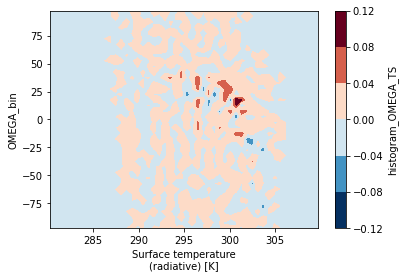

In [33]:
hTSW.plot.contourf()

In [34]:
#
# do better by getting the real $\omega_{500}$
dsps = xr.open_dataset(loc / "B1850_c201_CTL.cam.h0.0001-01.ncrcat.PS.nc", decode_times=False)
dsps = correct_time(dsps)
dsps = xr.decode_cf(dsps)
ps = dsps['PS']
print(ps)

<xarray.DataArray 'PS' (time: 361, lat: 192, lon: 288)>
[19961856 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0001-01-16 12:00:00 ... 0031-01-16 12:00:00
Attributes:
    units:         Pa
    long_name:     Surface pressure
    cell_methods:  time: mean


In [38]:
import geocat.comp as gc

In [46]:
%%time
omega = dsx['OMEGA']


CPU times: user 81 µs, sys: 1e+03 ns, total: 82 µs
Wall time: 86.1 µs


In [47]:
w500 = gc.interp_hybrid_to_pressure(omega, ps, dsx['hyam'], dsx['hybm'], lev_dim='lev')

AxisError: axis 1 is out of bounds for array of dimension 1

In [43]:
ps

<xarray.DataArray 'PS' (time: 361, lat: 192, lon: 288)>
[19961856 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0001-01-16 12:00:00 ... 0031-01-16 12:00:00
Attributes:
    units:         Pa
    long_name:     Surface pressure
    cell_methods:  time: mean